# Capstone Project
### Applied Data Science Capstone by IBM/Coursera
Edited by Qingzhu Yuan

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Acquisition and Cleaning](#data)
* [Methodology](#methodology)
* [Exploratoy Data Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

#### 1. Background
Shanghai is a well-known metropolitan city with a population of 24.28 million as of 2019. It is reputed as oriental Paris with its beauty of the combination of antique architectures and modern skyscrapers and its vibrant economic market, which has attracted thousands of people and businesses as well to rush into this city with their home town food. As for residents and visitors in Shanghai, it is quite convenient to reach any kind of cuisines and snacks, however, in terms of business owners, they should carefully take into consideration what kinds of restaurants or cafes should be open and how the business runs due to fierce competition.

How can applied data science help make decisions? Let's take the selection of the location of one new milk tea shop as an example. The methodology is similar to other shop selection.

#### B. Problems
As mentioned, the stakeholders would like to select the location to open a new milk tea shop. Few assumptions should be made here in advance, obtaining agreement with stakeholders:

1. The venue should be in the place with a comparatively high density of population, which can ensure the passengers flow rate.

2. The shop is better to close to potential customers such as students and young people because most young adults in 20 to 34 age buckets are drinking bubble tea as research has shown. Since I would like to apply foursquare API based on the geo-coordinates, we may pay attention to the places where young people would like to walk around or even stay, such as shopping malls, colleges, or restaurant areas.

#### C. Interest
The business owner of a milk tea shop is the stakeholder of this case. Besides, potential customers and competitors would also be interested in this study. Furthermore, the owner of other similar kinds of fast food stores or snack shops such as cafes or street food booths might be attracted to this study as well.

## Data Acquisition and Cleaning<a name="data"></a>

#### A. Data Acquisition
The data was achieved by web scraping.

In [2]:
#import library
import pandas as pd #dataframe
import numpy as np # library to handle data in a vectorized manner

import folium # map rendering

import requests # library to handle requests
from bs4 import BeautifulSoup # Web Scraping

import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
!conda install -c conda-forge geocoder -y
import geocoder # get coordinates library

Solving environment: ...working... done

# All requested packages already installed.



Firstly,Shanghai district data should be scrapped from web wiki, and stored in data frame.

In [3]:
# get page under url
def get_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'lxml')
    return soup

In [4]:
# create shanghai district table
tabledis = get_page("https://en.wikipedia.org/wiki/List_of_administrative_divisions_of_Shanghai").findAll('table',class_='wikitable')[1]
tabledis

<table cellspacing="0" class="wikitable" style="padding: 24em 0; border: 1px #aaa solid; border-collapse: collapse; font-size: 90%;">
<tbody><tr>
<th rowspan="2"></th>
<th colspan="8">County Level
</th></tr>
<tr>
<th>Name</th>
<th><a class="mw-redirect" href="/wiki/Simplified_Chinese" title="Simplified Chinese">Chinese</a></th>
<th><a class="mw-redirect" href="/wiki/Hanyu_Pinyin" title="Hanyu Pinyin">Hanyu Pinyin</a></th>
<th colspan="2"><a href="/wiki/Administrative_division_codes_of_the_People%27s_Republic_of_China" title="Administrative division codes of the People's Republic of China">Division code</a><sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup></th>
<th>Area (km²)<sup class="reference" id="cite_ref-census2018_3-0"><a href="#cite_note-census2018-3">[3]</a></sup></th>
<th>Population (2018 census)<sup class="reference" id="cite_ref-census2018_3-1"><a href="#cite_note-census2018-3">[3]</a></sup></th>
<th>Density (/km²)
</th></tr>
<tr>
<td bgcolor="#ffd35

In [5]:
tabledis_rows = tabledis.find_all('tr')

res = []
for tr in tabledis_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
        
df = pd.DataFrame(res)
df.head()

,0,1,2,3,4,5,6,7
0,Huangpu District[4](City seat),黄浦区,Huángpǔ Qū,310101,HGP,20.46,"653,800","31,955"
1,Xuhui District,徐汇区,Xúhuì Qū,310104,XHI,54.76,"1,084,400","19,803"
2,Changning District,长宁区,Chángníng Qū,310105,CNQ,38.30,"694,000","18,120"
3,Jing'an District,静安区,Jìng'ān Qū,310106,JAQ,36.88,"1,062,800","28,818"
4,Putuo District,普陀区,Pǔtuó Qū,310107,PTQ,54.83,"1,281,900","23,380"


In [6]:
# The District Name and Density is what we are interested in.
District = df[[0,7]].rename(columns={0:"District",7:"District Density(/km^2)"})
District.iloc[0,0]=District.iloc[0,0].replace('[4](City seat)','')
District.head()

,District,District Density(/km^2)
0,Huangpu District,"31,955"
1,Xuhui District,"19,803"
2,Changning District,"18,120"
3,Jing'an District,"28,818"
4,Putuo District,"23,380"


In [7]:
District = pd.DataFrame(District)
District.dtypes

District                   object
District Density(/km^2)    object
dtype: object

In [8]:
# Convert values from string to float in order to calcuate density of population.
import locale
from locale import atof
locale.setlocale(locale.LC_NUMERIC, '')

DD = District[['District Density(/km^2)']].applymap(atof)

Shanghai District Dataframe with Density data in **District Dataframe**

In [9]:
District = pd.concat([District[['District']],DD],axis=1)
District.head()

,District,District Density(/km^2)
0,Huangpu District,31955.0
1,Xuhui District,19803.0
2,Changning District,18120.0
3,Jing'an District,28818.0
4,Putuo District,23380.0


Secondly,sub-district data should also be found from web, stored and merged in data frame.

In [10]:
links_a = tabledis.find_all('a')

In [11]:
links_a[6].get('href')

'/wiki/Huangpu_District,_Shanghai'

In [12]:
# Achieve all links for sub-districts
link_subd = []
for i in range(6,23):
    link_subd.append(links_a[i].get('href')) 
link_subd

['/wiki/Huangpu_District,_Shanghai',
 '#cite_note-4',
 '/wiki/Xuhui_District',
 '/wiki/Changning_District',
 '/wiki/Jing%27an_District',
 '/wiki/Putuo_District,_Shanghai',
 '/wiki/Hongkou_District',
 '/wiki/Yangpu_District',
 '/wiki/Pudong',
 '/wiki/Minhang_District',
 '/wiki/Baoshan_District,_Shanghai',
 '/wiki/Jiading_District',
 '/wiki/Jinshan_District',
 '/wiki/Songjiang_District',
 '/wiki/Qingpu_District,_Shanghai',
 '/wiki/Fengxian_District',
 '/wiki/Chongming_District']

In [13]:
# remove certain wrong item in the list
link_subd.remove( '#cite_note-4')
link_subd

['/wiki/Huangpu_District,_Shanghai',
 '/wiki/Xuhui_District',
 '/wiki/Changning_District',
 '/wiki/Jing%27an_District',
 '/wiki/Putuo_District,_Shanghai',
 '/wiki/Hongkou_District',
 '/wiki/Yangpu_District',
 '/wiki/Pudong',
 '/wiki/Minhang_District',
 '/wiki/Baoshan_District,_Shanghai',
 '/wiki/Jiading_District',
 '/wiki/Jinshan_District',
 '/wiki/Songjiang_District',
 '/wiki/Qingpu_District,_Shanghai',
 '/wiki/Fengxian_District',
 '/wiki/Chongming_District']

In [14]:
# Try on finding the related district to the subdistrict
get_page('https://en.wikipedia.org'+link_subd[0]).find('title').text.replace(", Shanghai - Wikipedia","")

'Huangpu District'

In [15]:
# create a big table including all subdistricts
ressub =[]
Dis = []
for i in range(len(link_subd)):
    # scrap district name from web and merge to the table
    d = get_page('https://en.wikipedia.org'+link_subd[i]).find('title').text.replace(", Shanghai - Wikipedia","")
    Dis.append(d)
    Dis[i] = Dis[i].replace("- Wikipedia","")
    
    tablesub = get_page('https://en.wikipedia.org'+link_subd[i]).find('table',class_='wikitable')
    table_rows = tablesub.find_all('tr')

    for tr in table_rows:
        td = tr.find_all('td')
        row = [tr.text.strip() for tr in td if tr.text.strip()]
        if row:
            ressub.append([Dis[i]]+row)

tablesubdf = pd.DataFrame(ressub)
tablesubdf.head()

,0,1,2,3,4,5,6
0,Huangpu District,Bansongyuan Road Subdistrict,半淞园路街道,Bànsōngyuánlù Jiēdào,peu son yeu lu ka do,"89,776",2.87
1,Huangpu District,Huaihai Central Road Subdistrict,淮海中路街道,Huáihǎi Zhōnglù Jiēdào,wa he tzon lu ka do,"57,931",1.41
2,Huangpu District,Dapuqiao Subdistrict,打浦桥街道,Dǎpǔqiáo Jiēdào,tan phu djio ka do,"59,085",1.59
3,Huangpu District,Nanjing East Road Subdistrict,南京东路街道,Nánjīng Dōnglù Jiēdào,neu cin ton lu ka do,"66,285",2.41
4,Huangpu District,Laoximen Subdistrict,老西门街道,Lǎoxīmén Jiēdào,lo sij men ka do,"72,898",1.24


In [16]:
# Convert values from string to float in order to calcuate density of population.
a = tablesubdf[[5]].applymap(atof)
b = tablesubdf[6].astype(float) 

# We are interested in subdistrict name, population and area.
Subdis= tablesubdf[[0,1,5,6]].rename(columns={0:'District',1:'Subdistrict',5:'Population(2010)',6:'Area(km^2)'})

Density = pd.DataFrame([a.iloc[:,0]/b]).T.rename(columns={0:'Density(/km^2)'})
Subdis = pd.concat([Subdis,Density],axis=1)

print('There are totally {} subdistricts in Shanghai.'.format(Subdis.shape[0]))
Subdis.head()

There are totally 234 subdistricts in Shanghai.


,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2)
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677


In [17]:
# check if there is missing data in the table
Subdis.describe()

,Density(/km^2)
count,228.000000
mean,13681.627520
std,15554.105494
min,9.859155
25%,1196.161692
50%,4927.204233
75%,22931.833451
max,72255.147059


In [23]:
# The count of Density is less than the count of subdistricts, so we need to find out which data is missing and which area it is related to.
Subdis[Subdis.isnull().any(axis=1)]

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2)
55,Putuo District,Changzheng town,7.67,None,23380.0
123,Minhang District,Pujiang town,78.51,None,6860.0
173,Songjiang District,Guangfulin Subdistrict,19.05,None,2910.0
174,Songjiang District,Jiuliting Subdistrict,6.79,None,2910.0
188,Songjiang District,Songjiang Industrial Zone,43.69,None,2910.0
201,Fengxian District,Nanqiao town,114.68,None,1676.0


In [19]:
# import math library to add boolean value
import math
math.isnan(Subdis.loc[174,'Density(/km^2)'])

True

In [20]:
# The Density for item 174 of Songjiang District, Jiuliting Subdistrict is replaced with the data for Songjiang District
# .strip() to remove the possible space
# .loc[item in certain cell,index of column] means to select one row to make a new dataframe
# .iloc[0] to find out the value of that item on the index of the column
District.loc[District['District']==Subdis.iloc[174,0].strip(),'District Density(/km^2)'].iloc[0]

2910.0

In [21]:
# I'd like to use the same district density to cover the NaN for specific Subdistrict for all missing data.
for i in range(0,Subdis.shape[0]):
    if math.isnan(Subdis.loc[i,'Density(/km^2)']):
        Subdis.loc[i,'Density(/km^2)'] = District.loc[District['District']==Subdis.iloc[i,0].strip(),'District Density(/km^2)'].iloc[0]
        
Subdis[Subdis.isnull().any(axis=1)]

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2)
55,Putuo District,Changzheng town,7.67,None,23380.0
123,Minhang District,Pujiang town,78.51,None,6860.0
173,Songjiang District,Guangfulin Subdistrict,19.05,None,2910.0
174,Songjiang District,Jiuliting Subdistrict,6.79,None,2910.0
188,Songjiang District,Songjiang Industrial Zone,43.69,None,2910.0
201,Fengxian District,Nanqiao town,114.68,None,1676.0


Shanghai Sub-district with Density data in **Subdis Dataframe**

In [22]:
print(Subdis.shape[0])
Subdis.head()

234


,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2)
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677


Then,geological coordinates of sub-district data should be achieved by using geocorder, stored and merged in data frame.

In [24]:
def get_latlng(location,district):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{},{},Shanghai'.format(location,district))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [25]:
import time
latitude =[]
longitude=[]

for i in range(0,Subdis.shape[0]):
    district = Subdis.iloc[i,0]
    latitude.append(get_latlng(Subdis.iloc[i,1],district)[0])
    longitude.append(get_latlng(Subdis.iloc[i,1],district)[1])
    time.sleep(2)

Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Max retries exceeded with url: /arcgis/rest/services/World/GeocodeServer/find?f=json&text=Laoximen+Subdistrict%2CHuangpu+District%2CShanghai&maxLocations=1 (Caused by SSLError(SSLError("bad handshake: SysCallError(-1, 'Unexpected EOF')")))
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Max retries exceeded with url: /arcgis/rest/services/World/GeocodeServer/find?f=json&text=Pujiang+town%2CMinhang+District+%2CShanghai&maxLocations=1 (Caused by ProxyError('Cannot connect to proxy.', timeout('select timed out')))
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Max retries exceeded with url: /arcg

In [26]:
Subdis_latlng = pd.DataFrame({'latitude':latitude,'longitude':longitude})
print(Subdis_latlng.shape)
Subdis_latlng.head()

(234, 2)


,latitude,longitude
0,31.23780,121.47810
1,31.24055,121.19262
2,31.23780,121.47810
3,31.23780,121.47810
4,31.23780,121.47810


In [27]:
# concatenate dataframes
SubDistrict = pd.concat([Subdis,Subdis_latlng],axis=1)
SubDistrict.head()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237,31.23780,121.47810
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358,31.23780,121.47810
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378,31.23780,121.47810
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677,31.23780,121.47810


In [28]:
# double check if any outlier points
SubDistrict.describe()

,Density(/km^2),latitude,longitude
count,234.000000,234.000000,234.000000
mean,13504.517412,31.390507,116.279895
std,15439.710628,1.033089,31.389813
min,9.859155,30.723330,-76.735950
25%,1292.233720,31.096268,121.280403
50%,4829.483439,31.220000,121.418440
75%,22821.649030,31.299568,121.500618
max,72255.147059,37.588060,121.860100


In [29]:
# The min of longitude is very strange, and the max of latitude is also weird. We should look at those data.
SubDistrict[SubDistrict['longitude']<121]

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude
46,Jing'an District,Pengpu town,"152,725",7.88,19381.345178,37.58806,-76.73595
151,Jiading District,Malu town,"172,864",57.16,3024.212736,37.58806,-76.73595
208,Fengxian District,Haiwan town,"28,457",100.60,282.872763,37.58806,-76.73595
214,Chongming District,Bu town,"60,111",63.48,946.928166,37.58806,-76.73595
216,Chongming District,Miao town,"45,926",95.70,479.895507,37.58806,-76.73595
226,Chongming District,Xinhai town,"11,646",105.04,110.872049,37.58806,-76.73595
227,Chongming District,Dongping town,"15,112",119.70,126.248956,31.40344,108.75030


In [30]:
SubDistrict[SubDistrict['latitude']>32]

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude
46,Jing'an District,Pengpu town,"152,725",7.88,19381.345178,37.58806,-76.73595
151,Jiading District,Malu town,"172,864",57.16,3024.212736,37.58806,-76.73595
208,Fengxian District,Haiwan town,"28,457",100.60,282.872763,37.58806,-76.73595
214,Chongming District,Bu town,"60,111",63.48,946.928166,37.58806,-76.73595
216,Chongming District,Miao town,"45,926",95.70,479.895507,37.58806,-76.73595
226,Chongming District,Xinhai town,"11,646",105.04,110.872049,37.58806,-76.73595


In [31]:
# The data can be modified manually since the only few data should be modified.
# It take much more time on checking geocorder.
Pengpu = [31.306678, 121.449] # per check on google
Malu = [31.337447, 121.233592] # no found, refer to Jiading District
Haiwan = [30.883, 121.567] # no found, refer to Fengxian District
# no found, refer to Chongming
Bu = [31.666667, 121.5]
Miao = Bu
Xinhai = Bu
Dongping = Bu

SubDistrict.iloc[46,-2] = Pengpu[0]
SubDistrict.iloc[46,-1] = Pengpu[1]
SubDistrict.iloc[151,-2] = Malu[0]
SubDistrict.iloc[151,-1] = Malu[1]
SubDistrict.iloc[208,-2] = Haiwan[0]
SubDistrict.iloc[208,-1] = Haiwan[1]
SubDistrict.iloc[214,-2] = Bu[0]
SubDistrict.iloc[214,-1] = Bu[1]
SubDistrict.iloc[216,-2] = Bu[0]
SubDistrict.iloc[216,-1] = Bu[1]
SubDistrict.iloc[226,-2] = Bu[0]
SubDistrict.iloc[226,-1] = Bu[1]
SubDistrict.iloc[227,-2] = Bu[0]
SubDistrict.iloc[227,-1] = Bu[1]

SubDistrict.describe()

,Density(/km^2),latitude,longitude
count,234.000000,234.000000,234.000000
mean,13504.517412,31.233507,121.416284
std,15439.710628,0.236400,0.172806
min,9.859155,30.723330,121.009820
25%,1292.233720,31.094205,121.323630
50%,4829.483439,31.220000,121.421050
75%,22821.649030,31.298480,121.511438
max,72255.147059,31.831950,121.860100


Above **SubDistrict Dataframe** is Shanghai subdistrict table with density and coordinates data.

In [32]:
# save dataframe to csv.file
SubDistrict.to_csv (r'C:\Users\Administrator\Documents\IBM data science\8 Applied Data Science Capstone\shanghai_subdistricts_dataframe.csv', index = False, header=True)

I'd like to map the regions.

In [33]:
# take Downtown Shanghai as map center
latitude = 31.2304
longitude = 121.4737

# create map of Toronto using latitude and longitude values
map_shanghai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district, subdistrict in zip(SubDistrict['latitude'], SubDistrict['longitude'], SubDistrict['District'], SubDistrict['Subdistrict']):
    label = '{},{}'.format(subdistrict,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_shanghai)  
    
map_shanghai

With the above table, we are able to explore the venues in each regions.

In [34]:
# Define FourSquare Credentials and Version
CLIENT_ID = '13D1XGMOZEGUXSP0BIIG5HZFV1E020GTWIPJNFWFUMXYYS4O' # your Foursquare ID
CLIENT_SECRET = '2YH4LB3GE1WTDPQG401GNKKPXPE1Q5AZHAIWBDXGVGIHUWOT' # your Foursquare Secret
VERSION = '20200624' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 13D1XGMOZEGUXSP0BIIG5HZFV1E020GTWIPJNFWFUMXYYS4O
CLIENT_SECRET:2YH4LB3GE1WTDPQG401GNKKPXPE1Q5AZHAIWBDXGVGIHUWOT


In [35]:
# Let's try on the first subdistrict.
SubDistrict.loc[0,'Subdistrict']

'Bansongyuan Road Subdistrict'

In [36]:
Subdistrict_latitude = SubDistrict.loc[0, 'latitude'] # latitude value
Subdistrict_longitude = SubDistrict.loc[0, 'longitude'] # longitude value

Subdistrict_name = SubDistrict.loc[0,'Subdistrict'] # SubDistrict name

print('Latitude and longitude values of {} are {}, {}.'.format(Subdistrict_name, 
                                                               Subdistrict_latitude, 
                                                               Subdistrict_longitude))

Latitude and longitude values of Bansongyuan Road Subdistrict are 31.23780000000005, 121.47810000000004.


In [38]:
# First, let's create the GET request URL. Name your URL **url**.
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, Subdistrict_latitude, Subdistrict_longitude, VERSION, radius, LIMIT)

results = requests.get(url).json()
results['response']['groups'][0]['items'][0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '545718a4498ec939e658e228',
  'name': 'Épices & Foie-gras',
  'location': {'address': '309-A1-05 Hangkou Rd.',
   'crossStreet': 'Shandong Rd.',
   'lat': 31.23755713089388,
   'lng': 121.47958042912362,
   'labeledLatLngs': [{'label': 'display',
     'lat': 31.23755713089388,
     'lng': 121.47958042912362}],
   'distance': 143,
   'cc': 'CN',
   'neighborhood': 'Běixīn qiáo',
   'city': 'Huangpu',
   'state': '上海市',
   'country': '中国',
   'formattedAddress': ['309-A1-05 Hangkou Rd. (Shandong Rd.), Běixīn qiáo',
    'Huangpu',
    '上海市',
    '中国']},
  'categories': [{'id': '4bf58dd8d48988d10c941735',
    'name': 'French Restaurant',
    'pluralName': 'French Restaurants',
    'shortName': 'French',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_',
     'suffix': '.png'},
    'primary': True}],
  'ph

In [39]:
# Let's borrow the get_category_type function from the Foursquare lab.
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [40]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [41]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Épices & Foie-gras,French Restaurant,31.237557,121.479580
1,Bund Plaza,Department Store,31.239211,121.479741
2,M1NT Restaurant & Grill,Restaurant,31.236920,121.479641
3,Grand Central Hotel Shanghai (上海大酒店),Hotel,31.237379,121.476754
4,Nanjing Road Pedestrian Street (南京路步行街),Pedestrian Plaza,31.238273,121.476807


In [42]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

50 venues were returned by Foursquare.


#### Explore Subdistricts in Shanghai Downtown
Let's create a function to repeat the same process to all the Subdistricts in Shanghai Downtown.

In [50]:
# foursquare has limited calls for free personal account. Let's try on the downtown area of Shanghai.
shanghaidowntown = SubDistrict.loc[0:118,:]
shanghaidowntown.tail()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude
114,Pudong,Donghai Farm,508,15.20,33.421053,31.09611,121.79556
115,Pudong,Chaoyang Farm,862,10.67,80.787254,31.47150,121.79315
116,Pudong,Waigaoqiao Free-trade Zone,"1,349",10.00,134.900000,31.35589,121.57270
117,Pudong,Jinqiao Export Processing Zone,"5,514",67.79,81.339431,31.27092,121.59331
118,Pudong,Zhangjiang Hi-tech Park,"23,617",75.90,311.159420,31.20861,121.60889


In [113]:
shanghaidowntown.head()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237,31.23780,121.47810
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358,31.23780,121.47810
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378,31.23780,121.47810
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677,31.23780,121.47810


In [123]:
shanghaidowntown.shape

(119, 7)

In [43]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [51]:
shanghai_venues = getNearbyVenues(names=shanghaidowntown['Subdistrict'],
                                   latitudes=shanghaidowntown['latitude'],
                                   longitudes=shanghaidowntown['longitude']
                                  )

In [52]:
print('{} venues were returned by Foursquare for all subdistricts in Shanghai downtown.'.format(shanghai_venues.shape[0]))
shanghai_venues.head()

1618 venues were returned by Foursquare for all subdistricts in Shanghai downtown.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bansongyuan Road Subdistrict,31.2378,121.4781,Épices & Foie-gras,31.237557,121.479580,French Restaurant
1,Bansongyuan Road Subdistrict,31.2378,121.4781,Bund Plaza,31.239211,121.479741,Department Store
2,Bansongyuan Road Subdistrict,31.2378,121.4781,M1NT Restaurant & Grill,31.236920,121.479641,Restaurant
3,Bansongyuan Road Subdistrict,31.2378,121.4781,Grand Central Hotel Shanghai (上海大酒店),31.237379,121.476754,Hotel
4,Bansongyuan Road Subdistrict,31.2378,121.4781,Nanjing Road Pedestrian Street (南京路步行街),31.238273,121.476807,Pedestrian Plaza


In [116]:
shanghai_venues[shanghai_venues.isnull().any(axis=1)]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [53]:
# Let's check how many venues were returned for each neighborhood
shanghai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bansongyuan Road Subdistrict,50,50,50,50,50,50
Baoshan Road Subdistrict,47,47,47,47,47,47
Beicai town,1,1,1,1,1,1
Beixinjing Subdistrict,5,5,5,5,5,5
Beizhan Subdistrict[10],47,47,47,47,47,47
...,...,...,...,...,...,...
Zhenruzhen Subdistrict,6,6,6,6,6,6
Zhijiang West Road Subdistrict,47,47,47,47,47,47
Zhoujiadu Subdistrict,4,4,4,4,4,4


In [54]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(shanghai_venues['Venue Category'].unique())))

There are 97 uniques categories.


In [55]:
# save dataframe to csv.file
shanghai_venues.to_csv (r'C:\Users\Administrator\Documents\IBM data science\8 Applied Data Science Capstone\shanghai_venues_dataframe.csv', index = False, header=True)

## Methodology <a name="methodology"></a>

Firstly, the most common venues for each subdistrict should be achieved. Then, when the datasets are ready, we get started building a model to segment regions in Shanghai. The most popular method for partitioned-based clustering segmentation is the K-means algorithm, which divides the data into non-overlapping subsets without any cluster-internal structure.

Each cluster has its unique features which may help us select our stop location since we care about where our potential customers are. Besides, we also pay attention to the most crowded place to optimize the selection as mentioned very first in this study.

## Exploratory Data Analysis <a name="analysis"></a>

In [56]:
# make each venue catgory as column
# one hot encoding
shanghaidowntown_onehot = pd.get_dummies(shanghai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
shanghaidowntown_onehot['Neighborhood'] = shanghai_venues['Neighborhood'] 

# define a list of column names
cols = shanghaidowntown_onehot.columns.tolist()
cols.insert(0,cols.pop(cols.index('Neighborhood')))

shanghaidowntown_onehot = shanghaidowntown_onehot.reindex(columns=cols) 

shanghaidowntown_onehot.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,BBQ Joint,Bakery,Bar,Beer Bar,Big Box Store,Bookstore,...,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Toy / Game Store,Tunnel,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant
0,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
shanghaidowntown_grouped = shanghaidowntown_onehot.groupby('Neighborhood').mean().reset_index()
shanghaidowntown_grouped.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,BBQ Joint,Bakery,Bar,Beer Bar,Big Box Store,Bookstore,...,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Toy / Game Store,Tunnel,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant
0,Bansongyuan Road Subdistrict,0.000000,0.000000,0.02,0.0,0.020000,0.02,0.0,0.0,0.02,...,0.02,0.020000,0.02,0.020000,0.02,0.000000,0.0,0.000000,0.0,0.0
1,Baoshan Road Subdistrict,0.042553,0.021277,0.00,0.0,0.021277,0.00,0.0,0.0,0.00,...,0.00,0.021277,0.00,0.021277,0.00,0.021277,0.0,0.021277,0.0,0.0
2,Beicai town,0.000000,0.000000,1.00,0.0,0.000000,0.00,0.0,0.0,0.00,...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0
3,Beixinjing Subdistrict,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.0,0.0,0.00,...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0
4,Beizhan Subdistrict[10],0.042553,0.021277,0.00,0.0,0.021277,0.00,0.0,0.0,0.00,...,0.00,0.021277,0.00,0.021277,0.00,0.021277,0.0,0.021277,0.0,0.0


In [58]:
shanghaidowntown_grouped.shape

(95, 98)

In [59]:
num_top_venues = 5

for hood in shanghaidowntown_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = shanghaidowntown_grouped[shanghaidowntown_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bansongyuan Road Subdistrict----
                venue  freq
0               Hotel  0.14
1         Coffee Shop  0.08
2      Clothing Store  0.06
3  Chinese Restaurant  0.06
4       Shopping Mall  0.04


----Baoshan Road Subdistrict----
                  venue  freq
0    Chinese Restaurant  0.11
1   Japanese Restaurant  0.11
2           Coffee Shop  0.11
3  Fast Food Restaurant  0.06
4                 Hotel  0.06


----Beicai town----
                 venue  freq
0          Art Gallery   1.0
1  American Restaurant   0.0
2        Movie Theater   0.0
3                 Port   0.0
4          Pizza Place   0.0


----Beixinjing Subdistrict----
                  venue  freq
0  Fast Food Restaurant   0.4
1                  Park   0.2
2                Market   0.2
3         Metro Station   0.2
4   American Restaurant   0.0


----Beizhan Subdistrict[10]----
                  venue  freq
0    Chinese Restaurant  0.11
1   Japanese Restaurant  0.11
2           Coffee Shop  0.11
3  Fast Food Rest

                venue  freq
0               Hotel  0.14
1         Coffee Shop  0.08
2      Clothing Store  0.06
3  Chinese Restaurant  0.06
4       Shopping Mall  0.04


----Sanlin town----
                  venue  freq
0     Electronics Store  0.17
1  Fast Food Restaurant  0.17
2   Shanghai Restaurant  0.17
3        Shipping Store  0.17
4    Chinese Restaurant  0.17


----Shimen Second Road Subdistrict----
                  venue  freq
0    Chinese Restaurant  0.11
1   Japanese Restaurant  0.11
2           Coffee Shop  0.11
3  Fast Food Restaurant  0.06
4                 Hotel  0.06


----Shiquan Road Subdistrict----
                  venue  freq
0              Bus Stop  0.17
1  Fast Food Restaurant  0.17
2          Optical Shop  0.17
3                 Hotel  0.17
4          Soccer Field  0.17


----Sichuan North Road Subdistrict----
         venue  freq
0        Hotel  0.12
1         Café  0.08
2   Restaurant  0.08
3  Coffee Shop  0.08
4    Hotel Bar  0.08


----Siping Road Subdistri

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [62]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
shanghaidowntown_venues_sorted = pd.DataFrame(columns=columns)
shanghaidowntown_venues_sorted['Neighborhood'] = shanghaidowntown_grouped['Neighborhood']

for ind in np.arange(shanghaidowntown_grouped.shape[0]):
    shanghaidowntown_venues_sorted.iloc[ind, 1:] = return_most_common_venues(shanghaidowntown_grouped.iloc[ind, :], num_top_venues)

shanghaidowntown_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bansongyuan Road Subdistrict,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel
1,Baoshan Road Subdistrict,Coffee Shop,Chinese Restaurant,Japanese Restaurant,Hotel,Fast Food Restaurant,Lounge,Clothing Store,Pizza Place,American Restaurant,Bakery
2,Beicai town,Art Gallery,Yunnan Restaurant,Furniture / Home Store,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop
3,Beixinjing Subdistrict,Fast Food Restaurant,Park,Market,Metro Station,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store
4,Beizhan Subdistrict[10],Coffee Shop,Chinese Restaurant,Japanese Restaurant,Hotel,Fast Food Restaurant,Lounge,Clothing Store,Pizza Place,American Restaurant,Bakery


In [63]:
shanghaidowntown_venues_sorted.shape

(95, 11)

#### Clustering Neighborhoods

In [64]:
# try on KNN first
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [65]:
shanghaidowntown_grouped_clustering = shanghaidowntown_grouped.drop('Neighborhood', 1)

In [90]:
# choose best kclusters 
inertia =[]
kmax = 10
for k in range(2,kmax+1): 
        kmeans = KMeans(n_clusters=k,n_init=20,random_state=0).fit(shanghaidowntown_grouped_clustering)
        inertia.append(kmeans.inertia_) # the sum of squared distance to the nearest cluster centre

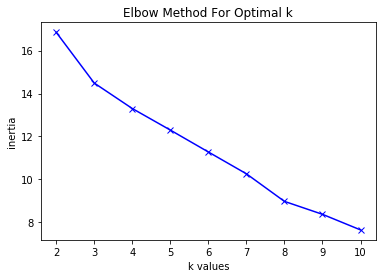

In [91]:
plt.plot(range(2,kmax+1),inertia,'bx-')
plt.xlabel('k values')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like K should be equal to 8 since here is big drop from 7 to 8.

In [98]:
# Let's try Silhouette Method
from sklearn.metrics import silhouette_score

sil = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
    kmeans = KMeans(n_clusters=k,n_init=20,random_state=0).fit(shanghaidowntown_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(shanghaidowntown_grouped_clustering, labels, metric = 'euclidean'))

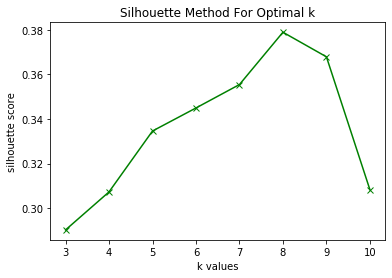

In [99]:
plt.plot(range(3,kmax+1),sil,'gx-')
plt.xlabel('k values')
plt.ylabel('silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [ ]:
# It looks like K should be equal to 8.

In [101]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init = "k-means++",n_clusters=kclusters, random_state=0,n_init = 20).fit(shanghaidowntown_grouped_clustering)

kmeans.labels_

array([0, 0, 7, 0, 0, 4, 4, 0, 3, 0, 0, 5, 0, 0, 0, 0, 2, 3, 4, 0, 6, 0,
       5, 0, 0, 1, 4, 0, 0, 3, 3, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 4, 0, 3, 3, 0, 0, 3, 5, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 2, 3,
       0, 0, 0, 0, 4, 0, 0, 0, 4, 3, 3, 0, 0, 4, 0, 0, 2, 0, 0, 0, 2, 0,
       5, 5, 0, 0, 0, 0, 0])

In [131]:
# add clustering labels
#shanghaidowntown_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

shanghaidowntown_merged = shanghaidowntown

# merge shanghaidowntown by adding latitude/longitude for each neighborhood
shanghaidowntown_merged = shanghaidowntown_merged.merge(shanghaidowntown_venues_sorted,left_on='Subdistrict',right_on='Neighborhood',how='left')

shanghaidowntown_merged.head() # check the last columns!

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237,31.23780,121.47810,0.0,Bansongyuan Road Subdistrict,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358,31.23780,121.47810,0.0,Dapuqiao Subdistrict,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378,31.23780,121.47810,0.0,Nanjing East Road Subdistrict,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677,31.23780,121.47810,0.0,Laoximen Subdistrict,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel


In [137]:
shanghaidowntown_merged = shanghaidowntown_merged.drop(columns = 'Neighborhood')
shanghaidowntown_merged.head()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237,31.23780,121.47810,0.0,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358,31.23780,121.47810,0.0,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378,31.23780,121.47810,0.0,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677,31.23780,121.47810,0.0,Hotel,Coffee Shop,Chinese Restaurant,Clothing Store,Shopping Mall,Café,Fast Food Restaurant,Cantonese Restaurant,Department Store,Hostel


In [138]:
shanghaidowntown_merged.shape

(119, 18)

In [139]:
shanghaidowntown_merged.tail()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
114,Pudong,Donghai Farm,508,15.20,33.421053,31.09611,121.79556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,Pudong,Chaoyang Farm,862,10.67,80.787254,31.47150,121.79315,5.0,Buffet,Hotel,Furniture / Home Store,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop
116,Pudong,Waigaoqiao Free-trade Zone,"1,349",10.00,134.900000,31.35589,121.57270,0.0,Bus Station,Chinese Restaurant,Metro Station,Yunnan Restaurant,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop
117,Pudong,Jinqiao Export Processing Zone,"5,514",67.79,81.339431,31.27092,121.59331,0.0,Recreation Center,Chinese Restaurant,Shanghai Restaurant,Yunnan Restaurant,Convenience Store,Department Store,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store
118,Pudong,Zhangjiang Hi-tech Park,"23,617",75.90,311.159420,31.20861,121.60889,5.0,Hotel,Lake,Grocery Store,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market


In [167]:
# save dataframe to csv.file
shanghaidowntown_merged.to_csv (r'C:\Users\Administrator\Documents\IBM data science\8 Applied Data Science Capstone\shanghaidowntown_merged.csv', index = False, header=True)

In [142]:
# find out which rows are missing data.
shanghaidowntown_merged[shanghaidowntown_merged.isnull().any(axis=1)]

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Xuhui District,Changqiao Subdistrict,"118,872",15.3,7769.411765,31.09674,121.07727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Xuhui District,Kangjian Xincun Subdistrict,"100,444",4.07,24679.115479,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Changning District,Huayang Road Subdistrict,"72,730",2.04,35651.960784,31.01090,121.28137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Changning District,Xianxia Xincun Subdistrict,"84,664",3.97,21325.944584,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,Putuo District,Caoyang Xincun Subdistrict,"98,267",1.36,72255.147059,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,Putuo District,Changfeng Xincun Subdistrict,"120,920",5.80,20848.275862,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,Putuo District,Changzheng town,7.67,None,23380.000000,31.23912,121.36779,0.0,Motorcycle Shop,Chinese Restaurant,Seafood Restaurant,Shopping Mall,Metro Station,Yunnan Restaurant,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store
61,Hongkou District,Liangcheng Xincun Subdistrict,"98,094",3.14,31240.127389,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Yangpu District,Changbai Xincun Subdistrict,"70,195",3.05,23014.754098,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
# find out the reason for NaN by foursquare.
# try on manually checking website on foursqure city guide, there are venues on huaihai central road.
# double check the lat,lon for huaihai road, which is wrong.
# so the root cause for row 1 with wrong coordinates is maybe because of the similar name of subdistricts.
# let's try again on row 1 item:
g = geocoder.arcgis('Huaihai Central Road,Huangpu,Shanghai')
g.latlng
# the result is incorrect...which is the other place in Shanghai called "Huaihai Cun".

[31.24055000000004, 121.19262000000003]

In [174]:
# let's look at Huaihai Road by google map location to find out a new name mark for arcgis to locate
g = geocoder.arcgis('Meilanfang,Huangpu,Shanghai')
g.latlng

[31.23780000000005, 121.47810000000004]

In [250]:
# The above data is the same coordinates to other subdistricts in Huangpu.
shanghaidowntown_merged.iloc[1,5]=shanghaidowntown_merged.iloc[0,5]
shanghaidowntown_merged.iloc[1,6]=shanghaidowntown_merged.iloc[0,6]

In [251]:
# Let's look at Xuhui District missing data by checking latlong.net
shanghaidowntown_merged.iloc[10,5]=31.138107
shanghaidowntown_merged.iloc[10,6]=121.437037
shanghaidowntown_merged.iloc[14,5]=31.166888
shanghaidowntown_merged.iloc[14,6]=121.417639

# Let's look at Xuhui, Huayang and Xianxia missing data and found there is no record online! 
# I decide to use the most common data for Changning, such as Jiangsu Road data
shanghaidowntown_merged.iloc[23,5]=shanghaidowntown_merged.iloc[24,5]
shanghaidowntown_merged.iloc[23,6]=shanghaidowntown_merged.iloc[24,6]
shanghaidowntown_merged.iloc[28,5]=shanghaidowntown_merged.iloc[24,5]
shanghaidowntown_merged.iloc[23,6]=shanghaidowntown_merged.iloc[24,6]

# Let's look at Putuo missing data
shanghaidowntown_merged.iloc[47,5]=31.235148
shanghaidowntown_merged.iloc[47,6]=121.417072
shanghaidowntown_merged.iloc[48,5]=31.369920
shanghaidowntown_merged.iloc[48,6]=121.716570

# Let's look at Hongkou missing data
# same latlng for other Hongkou subdistricts, so copy.
shanghaidowntown_merged.iloc[61,7:]=shanghaidowntown_merged.iloc[62,7:]

# Let's look at Yangpu missing data
shanghaidowntown_merged.iloc[71,5]=31.266491
shanghaidowntown_merged.iloc[71,6]=121.418631
shanghaidowntown_merged.iloc[73,5]=31.246027
shanghaidowntown_merged.iloc[73,6]=121.483385
# cannot find Changbai, use similar subdistricts in Yangpu
shanghaidowntown_merged.iloc[70,7:]=shanghaidowntown_merged.iloc[69,7:]

In [252]:
# Let's look at Pudong missing data
# found Weifang Xincun is located at fushan Road by google map
g = geocoder.arcgis('Fushan Road,Pudong,Shanghai')
shanghaidowntown_merged.iloc[77,5] = g.latlng[0]
shanghaidowntown_merged.iloc[77,6] = g.latlng[1]
shanghaidowntown_merged.iloc[77,:]

District                                     Pudong 
Subdistrict               Weifang Xincun Subdistrict
Population(2010)                             100,548
Area(km^2)                                      3.89
Density(/km^2)                               25847.8
latitude                                     31.2351
longitude                                    121.528
Cluster Labels                                   NaN
1st Most Common Venue                            NaN
2nd Most Common Venue                            NaN
3rd Most Common Venue                            NaN
4th Most Common Venue                            NaN
5th Most Common Venue                            NaN
6th Most Common Venue                            NaN
7th Most Common Venue                            NaN
8th Most Common Venue                            NaN
9th Most Common Venue                            NaN
10th Most Common Venue                           NaN
Name: 77, dtype: object

In [253]:
# found Shanggang Xincun is located at Xinjian Building by google map
g = geocoder.arcgis('Xinjian Building,Pudong,Shanghai')
shanghaidowntown_merged.iloc[81,5] = g.latlng[0]
shanghaidowntown_merged.iloc[81,6] = g.latlng[1]
shanghaidowntown_merged.iloc[81,:]

District                                       Pudong 
Subdistrict               Shanggang Xincun Subdistrict
Population(2010)                               104,932
Area(km^2)                                        7.54
Density(/km^2)                                 13916.7
latitude                                       31.7939
longitude                                      121.247
Cluster Labels                                     NaN
1st Most Common Venue                              NaN
2nd Most Common Venue                              NaN
3rd Most Common Venue                              NaN
4th Most Common Venue                              NaN
5th Most Common Venue                              NaN
6th Most Common Venue                              NaN
7th Most Common Venue                              NaN
8th Most Common Venue                              NaN
9th Most Common Venue                              NaN
10th Most Common Venue                             NaN
Name: 81, 

In [254]:
# found Jinyang Xincun is located at Zhangyang Bei Lu by google map
g = geocoder.arcgis('Zhangyang Bei Lu,Pudong,Shanghai')
shanghaidowntown_merged.iloc[84,5] = g.latlng[0]
shanghaidowntown_merged.iloc[84,6] = g.latlng[1]
shanghaidowntown_merged.iloc[84,:]

District                                     Pudong 
Subdistrict               Jinyang Xincun Subdistrict
Population(2010)                             206,017
Area(km^2)                                      8.02
Density(/km^2)                               25687.9
latitude                                     31.2351
longitude                                    121.528
Cluster Labels                                   NaN
1st Most Common Venue                            NaN
2nd Most Common Venue                            NaN
3rd Most Common Venue                            NaN
4th Most Common Venue                            NaN
5th Most Common Venue                            NaN
6th Most Common Venue                            NaN
7th Most Common Venue                            NaN
8th Most Common Venue                            NaN
9th Most Common Venue                            NaN
10th Most Common Venue                           NaN
Name: 84, dtype: object

In [188]:
# found Heqing town is called as Heqingzhen by google map
g = geocoder.arcgis('Heqingzhen,Pudong,Shanghai')
shanghaidowntown_merged.iloc[92,5] = g.latlng[0]
shanghaidowntown_merged.iloc[92,6] = g.latlng[1]
# found Datuan town is called Datuanzhen by google map
g = geocoder.arcgis('Datuanzhen,Pudong,Shanghai')
shanghaidowntown_merged.iloc[103,5] = g.latlng[0]
shanghaidowntown_merged.iloc[103,6] = g.latlng[1]
# similar to other towns..
g = geocoder.arcgis('Zhuqiaozhen,Pudong,Shanghai')
shanghaidowntown_merged.iloc[106,5] = g.latlng[0]
shanghaidowntown_merged.iloc[106,6] = g.latlng[1]

g = geocoder.arcgis('Xuanqiaozhen,Pudong,Shanghai')
shanghaidowntown_merged.iloc[108,5] = g.latlng[0]
shanghaidowntown_merged.iloc[108,6] = g.latlng[1]

g = geocoder.arcgis('Shuyuanzhen,Pudong,Shanghai')
shanghaidowntown_merged.iloc[109,5] = g.latlng[0]
shanghaidowntown_merged.iloc[109,6] = g.latlng[1]

g = geocoder.arcgis('Wanxiangzhen,Pudong,Shanghai')
shanghaidowntown_merged.iloc[110,5] = g.latlng[0]
shanghaidowntown_merged.iloc[110,6] = g.latlng[1]

g = geocoder.arcgis('Laogangzhen,Pudong,Shanghai')
shanghaidowntown_merged.iloc[111,5] = g.latlng[0]
shanghaidowntown_merged.iloc[111,6] = g.latlng[1]

g = geocoder.arcgis('Nahui Xinchengzhen,Pudong,Shanghai')
shanghaidowntown_merged.iloc[112,5] = g.latlng[0]
shanghaidowntown_merged.iloc[112,6] = g.latlng[1]

g = geocoder.arcgis('Binhai Forest Park,Pudong,Shanghai')
shanghaidowntown_merged.iloc[114,5] = g.latlng[0]
shanghaidowntown_merged.iloc[114,6] = g.latlng[1]

In [255]:
shanghaidowntown_merged[shanghaidowntown_merged.isnull().any(axis=1)]

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Xuhui District,Changqiao Subdistrict,"118,872",15.3,7769.411765,31.138107,121.437037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Xuhui District,Kangjian Xincun Subdistrict,"100,444",4.07,24679.115479,31.166888,121.417639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,Putuo District,Caoyang Xincun Subdistrict,"98,267",1.36,72255.147059,31.235148,121.417072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,Putuo District,Changfeng Xincun Subdistrict,"120,920",5.80,20848.275862,31.369920,121.716570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,Putuo District,Changzheng town,7.67,None,23380.000000,31.239120,121.367790,0.0,Motorcycle Shop,Chinese Restaurant,Seafood Restaurant,Shopping Mall,Metro Station,Yunnan Restaurant,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store
71,Yangpu District,Yanji Xincun Subdistrict,"90,334",2.04,44281.372549,31.266491,121.418631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,Yangpu District,Daqiao Subdistrict,"124,954",4.41,28334.240363,31.246027,121.483385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,Pudong,Weifang Xincun Subdistrict,"100,548",3.89,25847.814910,31.235130,121.527590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,Pudong,Shanggang Xincun Subdistrict,"104,932",7.54,13916.710875,31.793890,121.246940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Pudong,Jinyang Xincun Subdistrict,"206,017",8.02,25687.905237,31.235130,121.527590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [256]:
# need to re-find venues for Nan rows.
nanrows = shanghaidowntown_merged[shanghaidowntown_merged.isnull().any(axis=1)].drop([55],axis=0)
nanrows =nanrows.drop(nanrows.iloc[:,7:],axis=1)
nanrows.head()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude
10,Xuhui District,Changqiao Subdistrict,"118,872",15.3,7769.411765,31.138107,121.437037
14,Xuhui District,Kangjian Xincun Subdistrict,"100,444",4.07,24679.115479,31.166888,121.417639
47,Putuo District,Caoyang Xincun Subdistrict,"98,267",1.36,72255.147059,31.235148,121.417072
48,Putuo District,Changfeng Xincun Subdistrict,"120,920",5.80,20848.275862,31.369920,121.716570
71,Yangpu District,Yanji Xincun Subdistrict,"90,334",2.04,44281.372549,31.266491,121.418631


In [207]:
# explore venues for those rows.
nanrows_venues = getNearbyVenues(names=nanrows['Subdistrict'],
                                   latitudes=nanrows['latitude'],
                                   longitudes=nanrows['longitude']
                                  )

In [209]:
nanrows_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Changqiao Subdistrict,31.138107,121.437037,Laiyifen (来伊份),31.137831,121.434220,Snack Place
1,Changqiao Subdistrict,31.138107,121.437037,pizza ya,31.140434,121.433026,Pizza Place
2,Changqiao Subdistrict,31.138107,121.437037,仙芋鲜（嵩高路）,31.137769,121.431989,Dessert Shop
3,Kangjian Xincun Subdistrict,31.166888,121.417639,Gil wonton,31.164829,121.414498,Dumpling Restaurant
4,Kangjian Xincun Subdistrict,31.166888,121.417639,Color Grain,31.164651,121.414431,Café


In [226]:
nanrows_venues.shape[0]

79

In [225]:
# by refining the data, the venues are added by 79.
shanghai_venues_refined = pd.concat([shanghai_venues,nanrows_venues])
shanghai_venues_refined.shape[0]

1697

In [231]:
# save dataframe to csv.file
shanghai_venues_refined.to_csv (r'C:\Users\Administrator\Documents\IBM data science\8 Applied Data Science Capstone\shanghai_venues_refined.csv', index = False, header=True)

In [227]:
# make each venue catgory as column
# one hot encoding
shanghai_venues_refined_onehot = pd.get_dummies(shanghai_venues_refined[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
shanghai_venues_refined_onehot['Neighborhood'] = shanghai_venues_refined['Neighborhood'] 

# define a list of column names
cols = shanghai_venues_refined_onehot.columns.tolist()
cols.insert(0,cols.pop(cols.index('Neighborhood')))

shanghai_venues_refined_onehot = shanghai_venues_refined_onehot.reindex(columns=cols) 

shanghai_venues_refined_onehot.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Big Box Store,...,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Toy / Game Store,Tunnel,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant
0,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bansongyuan Road Subdistrict,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
shanghai_venues_refined_grouped = shanghai_venues_refined_onehot.groupby('Neighborhood').mean().reset_index()
shanghai_venues_refined_grouped.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Big Box Store,...,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Toy / Game Store,Tunnel,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant
0,Bansongyuan Road Subdistrict,0.000000,0.000000,0.02,0.0,0.020000,0.02,0.0,0.0,0.0,...,0.02,0.020000,0.02,0.020000,0.02,0.000000,0.0,0.000000,0.0,0.0
1,Baoshan Road Subdistrict,0.042553,0.021277,0.00,0.0,0.021277,0.00,0.0,0.0,0.0,...,0.00,0.021277,0.00,0.021277,0.00,0.021277,0.0,0.021277,0.0,0.0
2,Beicai town,0.000000,0.000000,1.00,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0
3,Beixinjing Subdistrict,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0
4,Beizhan Subdistrict[10],0.042553,0.021277,0.00,0.0,0.021277,0.00,0.0,0.0,0.0,...,0.00,0.021277,0.00,0.021277,0.00,0.021277,0.0,0.021277,0.0,0.0


In [230]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
shanghai_venues_refined_sorted = pd.DataFrame(columns=columns)
shanghai_venues_refined_sorted['Neighborhood'] = shanghai_venues_refined_grouped['Neighborhood']

for ind in np.arange(shanghai_venues_refined_grouped.shape[0]):
    shanghai_venues_refined_sorted.iloc[ind, 1:] = return_most_common_venues(shanghai_venues_refined_grouped.iloc[ind, :], num_top_venues)

shanghai_venues_refined_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bansongyuan Road Subdistrict,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
1,Baoshan Road Subdistrict,Coffee Shop,Chinese Restaurant,Japanese Restaurant,Hotel,Fast Food Restaurant,Lounge,Pizza Place,Clothing Store,American Restaurant,Bakery
2,Beicai town,Art Gallery,Yunnan Restaurant,Furniture / Home Store,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
3,Beixinjing Subdistrict,Fast Food Restaurant,Park,Market,Metro Station,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store
4,Beizhan Subdistrict[10],Coffee Shop,Chinese Restaurant,Japanese Restaurant,Hotel,Fast Food Restaurant,Lounge,Pizza Place,Clothing Store,American Restaurant,Bakery


In [232]:
shanghai_venues_refined_grouped_clustering = shanghai_venues_refined_grouped.drop('Neighborhood', 1)

In [233]:
# choose best kclusters 
inertia =[]
kmax = 10
for k in range(2,kmax+1): 
        kmeans = KMeans(n_clusters=k,n_init=20,random_state=0).fit(shanghai_venues_refined_grouped_clustering)
        inertia.append(kmeans.inertia_) # the sum of squared distance to the nearest cluster centre

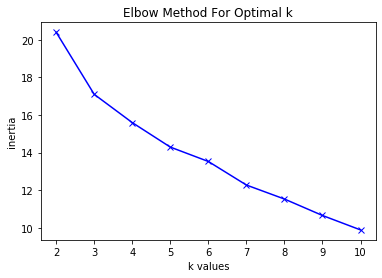

In [234]:
plt.plot(range(2,kmax+1),inertia,'bx-')
plt.xlabel('k values')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [235]:
# it looks like 7 is the best point.
# Let's try Silhouette Method

sil = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
    kmeans = KMeans(n_clusters=k,n_init=20,random_state=0).fit(shanghai_venues_refined_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(shanghai_venues_refined_grouped_clustering, labels, metric = 'euclidean'))

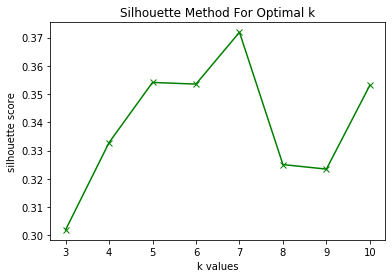

In [236]:
plt.plot(range(3,kmax+1),sil,'gx-')
plt.xlabel('k values')
plt.ylabel('silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [271]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(init = "k-means++",n_clusters=kclusters, random_state=0,n_init = 20).fit(shanghai_venues_refined_grouped_clustering)

kmeans.labels_

array([0, 0, 2, 0, 0, 5, 5, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 1,
       4, 4, 5, 0, 3, 0, 6, 0, 0, 0, 4, 5, 0, 0, 4, 4, 5, 5, 0, 1, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 1, 4, 0, 0, 5, 0, 4, 4, 4, 0, 0, 4, 6, 0, 0,
       0, 1, 4, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 5, 0, 0, 0, 5, 4, 4,
       4, 4, 0, 0, 5, 0, 0, 1, 0, 4, 0, 0, 0, 1, 0, 6, 6, 0, 0, 0, 0, 0,
       4])

In [243]:
len(shanghaidowntown)

119

In [242]:
shanghaidowntown.iloc[1,1]

'Huaihai Central Road Subdistrict'

In [258]:
nanrows.iloc[:,1]

10            Changqiao Subdistrict
14      Kangjian Xincun Subdistrict
47       Caoyang Xincun Subdistrict
48     Changfeng Xincun Subdistrict
71         Yanji Xincun Subdistrict
73               Daqiao Subdistrict
77       Weifang Xincun Subdistrict
81     Shanggang Xincun Subdistrict
84       Jinyang Xincun Subdistrict
85             Yangjing Subdistrict
92                      Heqing town
103                     Datuan Town
106                    Zhuqiao town
108                   Xuanqiao town
109                    Shuyuan town
110                   Wanxiang Town
111                    Laogang town
112          Nanhui Xincheng Town**
114                    Donghai Farm
Name: Subdistrict, dtype: object

In [262]:
shanghaidowntown_refined = shanghaidowntown

for i in range(0,len(shanghaidowntown)):
    for j in range(0,len(nanrows)):
        if shanghaidowntown.iloc[i,1] == nanrows.iloc[j,1]:
            shanghaidowntown.iloc[i,-2:] = nanrows.iloc[j,-2:]
    
shanghaidowntown_refined.head()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237,31.23780,121.47810
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358,31.23780,121.47810
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378,31.23780,121.47810
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677,31.23780,121.47810


In [263]:
shanghaidowntown_refined.iloc[14,:]

District                        Xuhui District 
Subdistrict         Kangjian Xincun Subdistrict
Population(2010)                        100,444
Area(km^2)                                 4.07
Density(/km^2)                          24679.1
latitude                                31.1669
longitude                               121.418
Name: 14, dtype: object

In [312]:
# add clustering labels
#shanghai_venues_refined_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

shanghai_refined_merged = shanghaidowntown_refined

# merge shanghaidowntown by adding latitude/longitude for each neighborhood
shanghai_refined_merged = shanghai_refined_merged.merge(shanghai_venues_refined_sorted,left_on='Subdistrict',right_on='Neighborhood',how='left')

shanghai_refined_merged.head() # check the last columns

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237,31.23780,121.47810,0.0,Bansongyuan Road Subdistrict,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358,31.23780,121.47810,0.0,Dapuqiao Subdistrict,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378,31.23780,121.47810,0.0,Nanjing East Road Subdistrict,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677,31.23780,121.47810,0.0,Laoximen Subdistrict,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store


In [313]:
shanghai_refined_merged[shanghai_refined_merged.isnull().any(axis=1)]

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Changning District,Huayang Road Subdistrict,"72,730",2.04,35651.960784,31.01090,121.28137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Changning District,Xianxia Xincun Subdistrict,"84,664",3.97,21325.944584,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,Putuo District,Changzheng town,7.67,None,23380.000000,31.23912,121.36779,0.0,Changzheng town,Chinese Restaurant,Seafood Restaurant,Shopping Mall,Metro Station,Motorcycle Shop,Yunnan Restaurant,Food,Dessert Shop,Discount Store,Dive Bar
61,Hongkou District,Liangcheng Xincun Subdistrict,"98,094",3.14,31240.127389,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Yangpu District,Changbai Xincun Subdistrict,"70,195",3.05,23014.754098,31.83195,121.32363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,Pudong,Shanggang Xincun Subdistrict,"104,932",7.54,13916.710875,31.79389,121.24694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Pudong,Yangjing Subdistrict,"146,237",7.38,19815.311653,30.87786,121.10125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,Pudong,Shuyuan town,"59,323",66.90,886.741405,30.93159,121.86019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [314]:
# As discussed before, if the coordinates are the same or similar to the other areas in that districts, just copy the rows.
# If not, delete the rows.
shanghai_refined_merged.iloc[1,7:18]=shanghai_refined_merged.iloc[0,7:18]
shanghai_refined_merged.iloc[23,7:18]=shanghai_refined_merged.iloc[24,7:18]
shanghai_refined_merged.iloc[28,7:18]=shanghai_refined_merged.iloc[24,7:18]
shanghai_refined_merged.iloc[61,7:18]=shanghai_refined_merged.iloc[62,7:18]
shanghai_refined_merged.iloc[70,7:18]=shanghai_refined_merged.iloc[69,7:18]

In [315]:
shanghai_refined_merged = shanghai_refined_merged.drop(columns = 'Neighborhood')
shanghai_refined_merged

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237,31.23780,121.47810,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
1,Huangpu District,Huaihai Central Road Subdistrict,"57,931",1.41,41085.815603,31.24055,121.19262,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,NaN
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358,31.23780,121.47810,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378,31.23780,121.47810,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677,31.23780,121.47810,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Pudong,Donghai Farm,508,15.20,33.421053,31.23513,121.52759,4.0,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Stadium,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Electronics Store,Farmers Market
115,Pudong,Chaoyang Farm,862,10.67,80.787254,31.47150,121.79315,6.0,Buffet,Hotel,Furniture / Home Store,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
116,Pudong,Waigaoqiao Free-trade Zone,"1,349",10.00,134.900000,31.35589,121.57270,0.0,Bus Station,Chinese Restaurant,Metro Station,Furniture / Home Store,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
117,Pudong,Jinqiao Export Processing Zone,"5,514",67.79,81.339431,31.27092,121.59331,0.0,Recreation Center,Chinese Restaurant,Shanghai Restaurant,Yunnan Restaurant,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store


In [316]:
shanghai_refined_merged = shanghai_refined_merged.dropna()

In [317]:
shanghai_refined_merged.head()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Huangpu District,Bansongyuan Road Subdistrict,"89,776",2.87,31280.836237,31.2378,121.4781,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
2,Huangpu District,Dapuqiao Subdistrict,"59,085",1.59,37160.377358,31.2378,121.4781,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
3,Huangpu District,Nanjing East Road Subdistrict,"66,285",2.41,27504.149378,31.2378,121.4781,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
4,Huangpu District,Laoximen Subdistrict,"72,898",1.24,58788.709677,31.2378,121.4781,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store
5,Huangpu District,Ruijin Second Road Subdistrict,"49,360",1.98,24929.292929,31.2378,121.4781,0.0,Hotel,Coffee Shop,Clothing Store,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Cantonese Restaurant,Café,French Restaurant,Department Store


In [318]:
shanghai_refined_merged[shanghai_refined_merged.isnull().any(axis=1)]

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [319]:
shanghai_refined_merged['Cluster Labels'] = shanghai_refined_merged['Cluster Labels'].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [324]:
shanghai_refined_merged.iloc[:,7].unique()

array([0, 5, 1, 4, 6, 2, 3], dtype=int64)

In [325]:
# save dataframe to csv.file
shanghai_refined_merged.to_csv (r'C:\Users\Administrator\Documents\IBM data science\8 Applied Data Science Capstone\shanghai_refined_merged.csv', index = False, header=True)

In [349]:
# Now we should focus on the factor of density of population
# Let's plot the bar to see the population density volumn
shanghai_pop = shanghai_refined_merged[['Subdistrict','Density(/km^2)']]
shanghai_pop.head()

,Subdistrict,Density(/km^2)
0,Bansongyuan Road Subdistrict,31280.836237
2,Dapuqiao Subdistrict,37160.377358
3,Nanjing East Road Subdistrict,27504.149378
4,Laoximen Subdistrict,58788.709677
5,Ruijin Second Road Subdistrict,24929.292929


In [369]:
shanghai_pop.set_index('Subdistrict',inplace=True)

In [392]:
shanghai_pop.describe()

,Density(/km^2)
count,110.000000
mean,21915.106617
std,17174.263451
min,33.421053
25%,4168.279199
50%,20970.940257
75%,33542.246647
max,72255.147059


In [395]:
shanghai_pop.iloc[1,0].astype(int)

37160

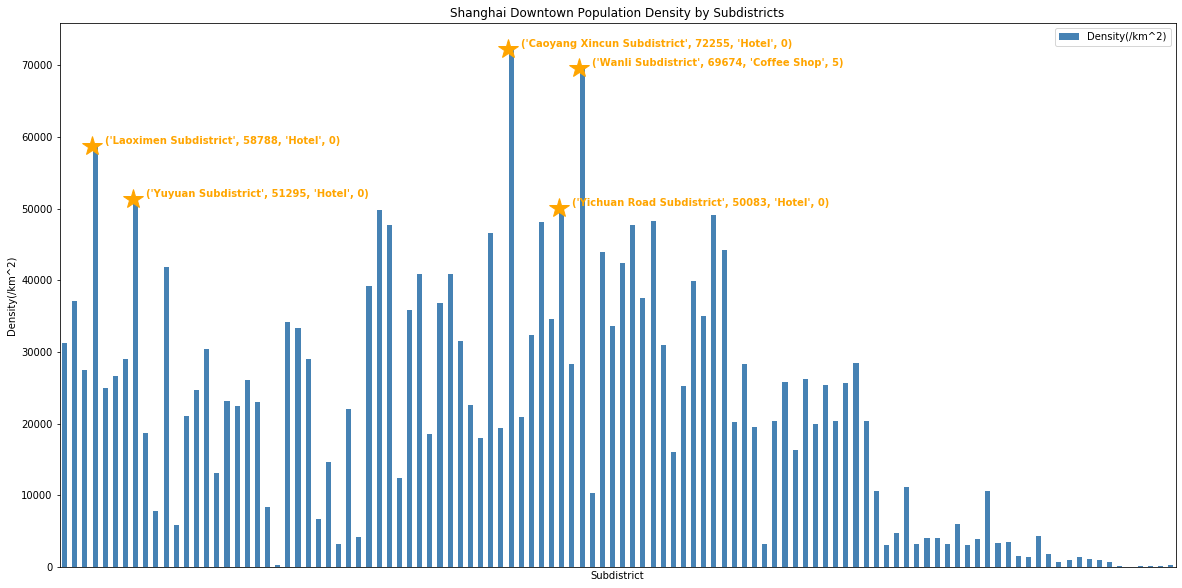

In [476]:
shanghai_pop.plot(kind='bar', 
             stacked=False,
             figsize=(20, 10), # pass a tuple (x, y) size
             color='steelblue'
             )

plt.title('Shanghai Downtown Population Density by Subdistricts')
plt.ylabel('Density(/km^2)')
plt.xlabel('Subdistrict')
plt.xticks([])

for i in range(0,len(shanghai_pop)):
    if shanghai_pop.iloc[i,0] > 50000:
        label = shanghai_pop.index[i], shanghai_pop.iloc[i,0].astype(int), shanghai_refined_merged.iloc[i,8],shanghai_refined_merged.iloc[i,7]
        plt.annotate(label,
                     xy=(i+1,shanghai_pop.iloc[i,0]+10),
                     fontsize = 10,
                     fontweight='bold',
                     va = 'bottom',
                     ha = 'left',
                     color = 'orange'
                    )
        plt.plot(i-0.3, shanghai_pop.iloc[i,0]+1, marker='*', markersize = 20, color='orange')

plt.show()

In [475]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude],tiles="Stamen Toner",zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, density in zip(shanghai_refined_merged['latitude'], shanghai_refined_merged['longitude'], shanghai_refined_merged['Subdistrict'], shanghai_refined_merged['Cluster Labels'],shanghai_refined_merged['Density(/km^2)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        location = [lat,lon],
        popup=label,
        radius = 5 + density/50,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [8]:
# open csv.file due to the jupyter book closed
shanghai_refined_merged = pd.read_csv(r'C:\Users\Administrator\Documents\IBM data science\8 Applied Data Science Capstone\shanghai_refined_merged.csv')
shanghai_refined_merged.head()

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pudong,Donghai Farm,508,15.20,33.421053,31.23513,121.52759,4,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Stadium,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Electronics Store,Farmers Market
1,Pudong,Luchaogang Farm,688,9.40,73.191489,31.23513,121.52759,4,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Stadium,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Electronics Store,Farmers Market
2,Pudong,Chaoyang Farm,862,10.67,80.787254,31.47150,121.79315,6,Buffet,Hotel,Furniture / Home Store,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
3,Pudong,Jinqiao Export Processing Zone,"5,514",67.79,81.339431,31.27092,121.59331,0,Recreation Center,Chinese Restaurant,Shanghai Restaurant,Yunnan Restaurant,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store
4,Pudong,Waigaoqiao Free-trade Zone,"1,349",10.00,134.900000,31.35589,121.57270,0,Bus Station,Chinese Restaurant,Metro Station,Furniture / Home Store,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant


In [9]:
c0 = shanghai_refined_merged.loc[shanghai_refined_merged['Cluster Labels'] == 0, shanghai_refined_merged.columns[list(range(0, shanghai_refined_merged.shape[1]))]].sort_values(by=['Density(/km^2)'],ascending=False).head()

In [10]:
c1 = shanghai_refined_merged.loc[shanghai_refined_merged['Cluster Labels'] == 1, shanghai_refined_merged.columns[list(range(0, shanghai_refined_merged.shape[1]))]].sort_values(by=['Density(/km^2)'],ascending=False).head()

In [11]:
c2 = shanghai_refined_merged.loc[shanghai_refined_merged['Cluster Labels'] == 2, shanghai_refined_merged.columns[list(range(0, shanghai_refined_merged.shape[1]))]].sort_values(by=['Density(/km^2)'],ascending=False).head()

In [12]:
c3 = shanghai_refined_merged.loc[shanghai_refined_merged['Cluster Labels'] == 3, shanghai_refined_merged.columns[list(range(0, shanghai_refined_merged.shape[1]))]].sort_values(by=['Density(/km^2)'],ascending=False).head()

In [13]:
c4 = shanghai_refined_merged.loc[shanghai_refined_merged['Cluster Labels'] == 4, shanghai_refined_merged.columns[list(range(0, shanghai_refined_merged.shape[1]))]].sort_values(by=['Density(/km^2)'],ascending=False).head()

In [14]:
c5 = shanghai_refined_merged.loc[shanghai_refined_merged['Cluster Labels'] == 5, shanghai_refined_merged.columns[list(range(0, shanghai_refined_merged.shape[1]))]].sort_values(by=['Density(/km^2)'],ascending=False).head()

In [15]:
c6 = shanghai_refined_merged.loc[shanghai_refined_merged['Cluster Labels'] == 6, shanghai_refined_merged.columns[list(range(0, shanghai_refined_merged.shape[1]))]].sort_values(by=['Density(/km^2)'],ascending=False).head()

In [16]:
c0.iloc[0,:]

District                              Putuo District
Subdistrict               Caoyang Xincun Subdistrict
Population(2010)                              98,267
Area(km^2)                                      1.36
Density(/km^2)                               72255.1
latitude                                     31.2351
longitude                                    121.417
Cluster Labels                                     0
1st Most Common Venue                          Hotel
2nd Most Common Venue                         Bakery
3rd Most Common Venue                            Gym
4th Most Common Venue                        Stadium
5th Most Common Venue              Yunnan Restaurant
6th Most Common Venue              French Restaurant
7th Most Common Venue                   Dessert Shop
8th Most Common Venue                 Discount Store
9th Most Common Venue                       Dive Bar
10th Most Common Venue           Dumpling Restaurant
Name: 109, dtype: object

In [45]:
# find out largest density in each cluster with the most common three venues and make plots
clustertable = pd.DataFrame([c0.iloc[0,:],c1.iloc[0,:],c2.iloc[0,:],c3.iloc[0,:],c4.iloc[0,:],c5.iloc[0,:],c6.iloc[0,:]])
clustertable

,District,Subdistrict,Population(2010),Area(km^2),Density(/km^2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
109,Putuo District,Caoyang Xincun Subdistrict,"98,267",1.36,72255.147060,31.235148,121.417072,0,Hotel,Bakery,Gym,Stadium,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant
103,Yangpu District,Kongjiang Subdistrict,"105,613",2.15,49122.325580,31.261930,121.519040,1,Seafood Restaurant,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
38,Pudong,Beicai town,"276,547",24.91,11101.846650,31.189720,121.548060,2,Art Gallery,Yunnan Restaurant,Furniture / Home Store,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
17,Pudong,Gaodong town,"110,552",36.24,3050.551876,31.333330,121.616670,3,Farmers Market,Yunnan Restaurant,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Flower Shop
73,Pudong,Puxing Road Subdistrict,"177,468",6.25,28394.880000,31.235130,121.527590,4,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Stadium,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Electronics Store,Farmers Market
108,Putuo District,Wanli Subdistrict,"229,925",3.30,69674.242420,31.085160,121.528980,5,Coffee Shop,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
29,Pudong,Gaoqiao town,"184,486",38.73,4763.387555,31.350550,121.573300,6,Hotel,Noodle House,Chinese Restaurant,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market


In [46]:
clustertable.iloc[:,8:18]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
109,Hotel,Bakery,Gym,Stadium,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant
103,Seafood Restaurant,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
38,Art Gallery,Yunnan Restaurant,Furniture / Home Store,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
17,Farmers Market,Yunnan Restaurant,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Flower Shop
73,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Stadium,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Electronics Store,Farmers Market
108,Coffee Shop,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
29,Hotel,Noodle House,Chinese Restaurant,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market


In [47]:
colorlist = clustertable.iloc[:,8:18].to_numpy()
colorlist

array([['Hotel', 'Bakery', 'Gym', 'Stadium', 'Yunnan Restaurant',
        'French Restaurant', 'Dessert Shop', 'Discount Store',
        'Dive Bar', 'Dumpling Restaurant'],
       ['Seafood Restaurant', 'Yunnan Restaurant', 'French Restaurant',
        'Dessert Shop', 'Discount Store', 'Dive Bar',
        'Dumpling Restaurant', 'Electronics Store', 'Farmers Market',
        'Fast Food Restaurant'],
       ['Art Gallery', 'Yunnan Restaurant', 'Furniture / Home Store',
        'Dessert Shop', 'Discount Store', 'Dive Bar',
        'Dumpling Restaurant', 'Electronics Store', 'Farmers Market',
        'Fast Food Restaurant'],
       ['Farmers Market', 'Yunnan Restaurant', 'Deli / Bodega',
        'Dessert Shop', 'Discount Store', 'Dive Bar',
        'Dumpling Restaurant', 'Electronics Store',
        'Fast Food Restaurant', 'Flower Shop'],
       ['Coffee Shop', 'Dumpling Restaurant', 'Chinese Restaurant',
        'Stadium', 'Yunnan Restaurant', 'French Restaurant',
        'Discount Store'

In [48]:
len(np.unique(colorlist))

21

In [49]:
mostcm = clustertable.iloc[:,7:18]
mostcm

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
109,0,Hotel,Bakery,Gym,Stadium,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant
103,1,Seafood Restaurant,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
38,2,Art Gallery,Yunnan Restaurant,Furniture / Home Store,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
17,3,Farmers Market,Yunnan Restaurant,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Flower Shop
73,4,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Stadium,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Electronics Store,Farmers Market
108,5,Coffee Shop,Yunnan Restaurant,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
29,6,Hotel,Noodle House,Chinese Restaurant,Yunnan Restaurant,French Restaurant,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Farmers Market


In [50]:
cc = []
for i in range(0,21):
    cc.append(10 + i)
cc

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [51]:
uniquecol = list(zip(np.unique(colorlist),cc))
uniquecol

[('Art Gallery', 10),
 ('Bakery', 11),
 ('Chinese Restaurant', 12),
 ('Coffee Shop', 13),
 ('Deli / Bodega', 14),
 ('Dessert Shop', 15),
 ('Discount Store', 16),
 ('Dive Bar', 17),
 ('Dumpling Restaurant', 18),
 ('Electronics Store', 19),
 ('Farmers Market', 20),
 ('Fast Food Restaurant', 21),
 ('Flower Shop', 22),
 ('French Restaurant', 23),
 ('Furniture / Home Store', 24),
 ('Gym', 25),
 ('Hotel', 26),
 ('Noodle House', 27),
 ('Seafood Restaurant', 28),
 ('Stadium', 29),
 ('Yunnan Restaurant', 30)]

In [52]:
len(uniquecol)

21

In [56]:
x = []
y = []
dx = []
col = []

for i in range(0,mostcm.shape[0]):
    for j in range(0,10): # explore top10 most common venues
        x.append(i)
        y.append(j)
        dx.append(0.98) # square size
        for h in range(0,21): # unique color
            if mostcm.iloc[i,j+1]== uniquecol[h][0]:
                col.append(uniquecol[h][1])

print('x = ',x)
print('y = ',y)
print('dx =',dx)
print('col =',col)

x =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
y =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dx = [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98]
col = [26, 11, 25, 29, 30, 23, 15, 16, 17, 18, 28, 30, 23, 15, 16, 17, 18, 19, 20, 21, 10, 30, 24, 15, 16, 17, 18, 19, 20, 21, 20, 30, 14, 15,

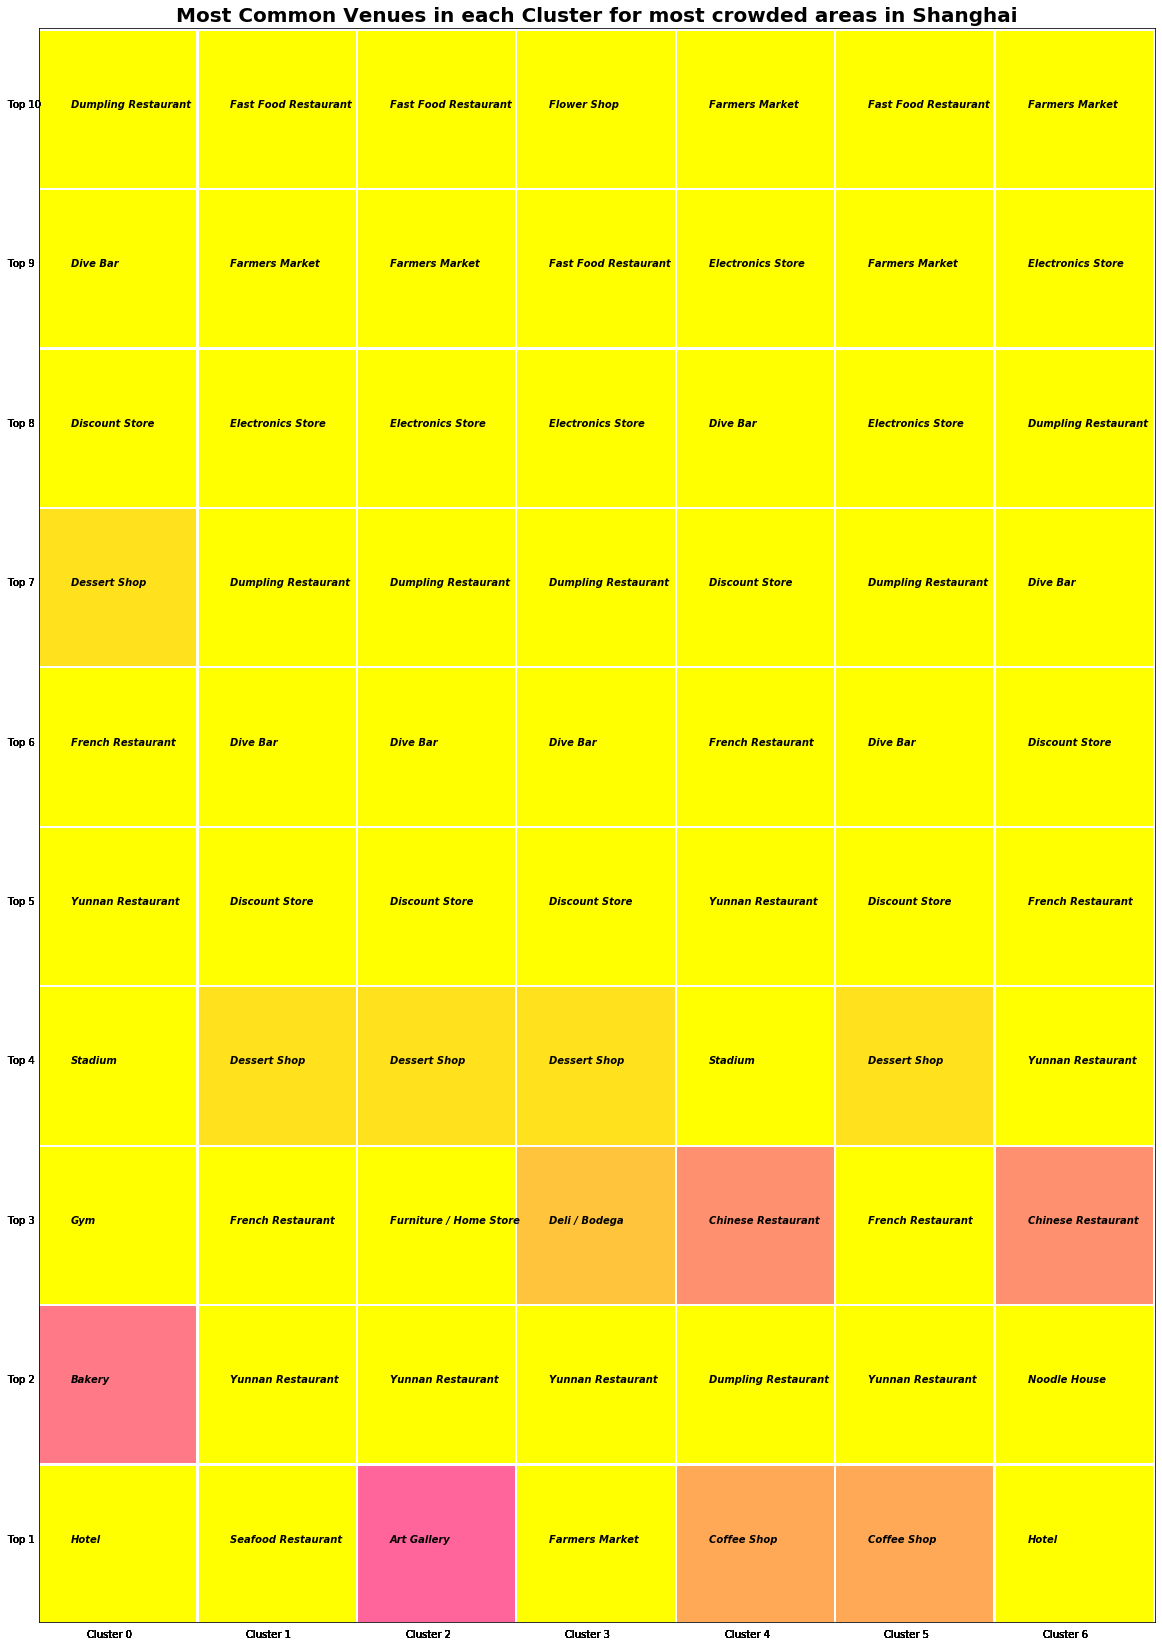

In [68]:
from matplotlib.patches import Rectangle
cmap = plt.cm.spring
fig = plt.figure(figsize=(20,40))
ax = fig.add_subplot(111, xlim=(0,7),ylim=(0,10),aspect='equal')
for x, y, c, h in zip(x, y, col, dx):
    ax.add_artist(Rectangle(xy=(x, y),
                  color=cmap(c**2),
                  width=h, height=h)) 

ax.set_title('Most Common Venues in each Cluster for most crowded areas in Shanghai',fontsize = 20,fontweight='bold')    
ax.set_xticks([])
ax.set_yticks([])

for i in range(0,7):
    for j in range(0,10):
        ax.text(i+0.3, -0.1, 'Cluster {}'.format(i), size =10)
        ax.text(-0.2, j+0.5, 'Top {}'.format(j+1), size = 10)
        ax.text(i+0.2, j+0.5, mostcm.iloc[i,j+1], size=10, style='italic',fontweight='bold')

plt.show()

## Results and Discussion <a name="results"></a>

If we assumpted that our data sets were correct and sufficient, from the seven clusters, we would say cluster 1 has its advantage of all restaurants and discount stores listed in the top 5 venues, compared to other clusters, the highest density of cluster 1 is Kongjiang Subdistrict in Yangpu area.

In terms of the high-density area in the Shanghai downtown area, the Caoyang Xincun area in Putuo belonging to cluster 0 is also an alternative choice because the top third venue is GYM which the main customers are young people as usual. Besides, I also recommend the fourth most crowded regions in Shanghai downtown, which is Laoximen in Huangpu in cluster 0, because its top3 and top5 venues are clothing stores and shopping malls which usually attract young adults to visit, even though top 1 is a coffee shop which may bring competition to the milk tea shop.

Based on the above observation, I would recommend Kongjiang in Yangpu, Caoyang Xincun in Putuo, and Laoximen in Huangpu to the stakeholder.

Meanwhile, I am curious about other factors that may impact the final decision. For example, the rent cost and the current milk tea shops in that region may also be the obvious data that stakeholder is interested in. Those data is not hard to find out online, and we may provide our final choice suggestion by using Pugh Matrix to stakeholders if he or she did not have other factors that need to consider.

| District | Subdistrict | Density(/m^2) | Cluster | Choice Reasons | Milk Tea Shop No. | Average Rent Cost(RMB/m^2/day) |
|----------|-------------|---------------|---------|----------------|-------------------|--------------------------------|
| Yangpu | Kongjiang | 49122 | 1 | restaurants and discount stores listed in top 5 venues | 46 | 3.5 |
| Putuo | Caoyang | 72255 | 0 | most crowded place,Gym as top third venue | 140| 7.5 |
| Huangpu | Laoximen | 58788 | 0 | top3 and top5 are clothing stores and shopping malls | 75 | 10 |

| District | Subdistrict | Density(/m^2) | Cluster Features | Competition | Rent Cost |
|----------|-------------|:-------------:|:--------:|:-----------:|:--------:|
| Yangpu | Kongjiang | - | + | + | + |
| Putuo | Caoyang   | + | - | - | o |
| Huangpu | Laoximen | o | o | o | - |

## Conclusion <a name="conclusion"></a>

In this study, the data of Shanghai subdistricts was scrapped from Wikipedia, cleaned to a well-stored data frame, visualized by a folium map. The geo-coordinates were achieved by using geocoder and the exploration of surrounding area venues was implemented with the support of Foursquare API. By the application of the K-means clustering algorithm, subdistricts were segmented into seven clusters. In the consideration of cluster, population density, and other factors, the location for opening a new milk tea shop was finally selected.

During the process of data scientific study of the selection of location to a new milk tea shop, not only several basic and important libraries, APIs and functions are practiced with the help of huge open sources available online, but also the skills of data analysis, especially during the pro-precessing and post summary is deeply improved with personal judgment and assertiveness. 

I admit that the result and analysis process is far from perfect, but the beginning is the hardest part, and I have begun the magic journey of data science. Here is the link for all python code for this project shared in my Github, and I feel appreciated that you read all through my report here. At last, I sincerely thank Coursera and IBM for their fantastic data science courses.